- ### Alternative mit custom kernel https://docs.oceanparcels.org/en/latest/examples/parcels_tutorial.html

In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
from dask.distributed import Client

In [3]:
import numpy as np

In [4]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit=8e9, ip="0.0.0.0")
client

/opt/conda/lib/python3.10/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42157 instead
  warnings.warn(
2023-06-26 12:05:19,764 - distributed.diskutils - INFO - Found stale lock file and directory '/work/notebooks/dask-worker-space/worker-j86gdanr', purging
2023-06-26 12:05:19,770 - distributed.diskutils - INFO - Found stale lock file and directory '/work/notebooks/dask-worker-space/worker-r_5oz45o', purging
2023-06-26 12:05:19,776 - distributed.diskutils - INFO - Found stale lock file and directory '/work/notebooks/dask-worker-space/worker-ci9uq6l8', purging
2023-06-26 12:05:19,780 - distributed.diskutils - INFO - Found stale lock file and directory '/work/notebooks/dask-worker-space/worker-_hoys4o7', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://134.245.3.15:42157/status,
Dashboard: http://134.245.3.15:42157/status,Workers: 4
Total threads: 8,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://134.245.3.15:43211,Workers: 4
Dashboard: http://134.245.3.15:42157/status,Total threads: 8
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://134.245.3.15:34525,Total threads: 2
Dashboard: http://134.245.3.15:38135/status,Memory: 7.45 GiB
Nanny: tcp://134.245.3.15:41095,


In [5]:
INALT_ds = xr.open_dataset('../output_data/INALT20.L46-KFS119/Column_test_4000_20090301_RT-42_N-1000000_seed-12345.nc') #INALT20.L46-KFS119
INALT_ds

<xarray.Dataset>
Dimensions:     (traj: 1000000, obs: 46)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 ...
    lat         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    trajectory  (traj, obs) float64 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

In [6]:
INALT_2weeks=INALT_ds.where((INALT_ds.obs<[7*2+1]),drop=True) # 2 weeks

In [7]:
INALT_2weeks=INALT_2weeks.dropna("traj")
INALT_2weeks

<xarray.Dataset>
Dimensions:     (traj: 999993, obs: 15)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 8.313 8.302 8.292 ... 8.097 8.087 8.077
    lat         (traj, obs) float64 -23.14 -23.14 -23.14 ... -23.06 -23.07
    z           (traj, obs) float64 638.5 638.1 639.3 ... 707.5 707.0 707.3
    time        (traj, obs) datetime64[ns] 2009-03-01 2009-03-02 ... 2009-03-18
    trajectory  (traj, obs) float64 0.0 0.0 0.0 0.0 ... 1e+06 1e+06 1e+06 1e+06
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

In [8]:
# Initial positions and last positions
end=INALT_2weeks.isel(obs=7*2-1)
start=INALT_2weeks.isel(obs=0)

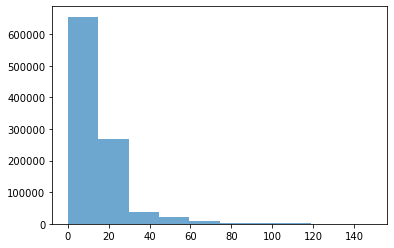

In [9]:
#Distance determination

dist_years_mean = []
dist_years_min = []
dist_years_max = []
dist_n = []
distances = []

for i in range(len(start.traj)): 
    lon1 = start.isel(traj=i)['lon'].compute().data
    lon2 = end.isel(traj=i)['lon'].compute().data
    lat1 = start.isel(traj=i)['lat'].compute().data
    lat2 = end.isel(traj=i)['lat'].compute().data
            
    dx = 111.3 * np.cos(np.deg2rad((lat1+lat2)/2))  * (lon1 - lon2)
    dy = 111.3 * (lat1 - lat2)
            
    distance = np.sqrt(dx**2 + dy**2)
    distances.append(distance)
        
plt.hist(distances, alpha = 0.65)
dist_years_mean.append(np.mean(distances))
dist_years_min.append(np.min(distances))  
dist_years_max.append(np.max(distances))  
dist_n.append(len(distances))

In [10]:
print(dist_n)
print(dist_years_mean)

[999993]
[13.88875671955542]


In [11]:
percentile = np.percentile(distances, 95)
percentile

38.04001186406964

In [12]:
distances = np.array(distances)

In [13]:
filtered = []

for distances in distances:
    if distances < percentile:
        filtered.append(distances)

In [14]:
np.mean(filtered)

11.54130934708532